In [1]:
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2)
        )
        
        self.Decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.Encoder(x)
        
        x = self.Decoder(x)
        
        return x

In [2]:
import torch.nn.functional as F

def loss_batch(output, source, target, loss_func, opt=None):
    
    loss = loss_func(output, target)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    
    return loss.item(), len(target)

In [3]:
import numpy as np
from torchvision.utils import save_image


def train(epochs, model, train_dl, valid_dl, loss_func, opt, out_dir, device):
    loss_record = 100
    for epoch in range(epochs):
        
        model.train()
        for source, target in train_dl:
            source, target = source.view(-1,28*28).to(device), target.to(device)
            output = model(source)
            loss_batch(output, source, source, loss_func, opt)
            
        
        model.eval()
        with torch.no_grad():
            losses = []
            nums = []
            for source, target in valid_dl:
                source, target = source.view(-1,28*28).to(device), target.to(device)
                output = model(source)
                loss, num = loss_batch(output, source, source, loss_func) 
                losses.append(loss)
                nums.append(num)
            if epoch%10==0:
                pic = torch.cat((output, source), 0)
                pic = pic.view(pic.size(0),1,28,28)
                #save_image(pic, './{}/image_{}.png'.format(out_dir, epoch))
            
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            if valid_loss < loss_record:
                #torch.save(model.state_dict(),'./{}/ae_model.pth'.format(out_dir))
                #print("save model epoch {} {}".format(epoch, valid_loss))
                loss_record = valid_loss
            if epoch%10==0:
                print(epoch, valid_loss)
                

In [4]:
import torch
import torchvision
from torchvision import transforms
from torch.utils import data
from torch.utils.data import TensorDataset, DataLoader
bs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


data_transform = transforms.Compose([
    transforms.ToTensor()
])

training_data = torchvision.datasets.MNIST(root='./data',train=True,transform=data_transform,download=True)
train_ds, valid_ds = data.random_split(training_data,lengths=[50000, 10000])
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

0it [00:00, ?it/s]

 97%|█████████▋| 9625600/9912422 [00:12<00:00, 2317537.74it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 61438.63it/s]
32768it [00:00, 40271.20it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz



100%|█████████▉| 1646592/1648877 [00:06<00:00, 465086.47it/s]

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 15170.20it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


9920512it [00:30, 2317537.74it/s]                             

torch.Size([1, 28, 28])


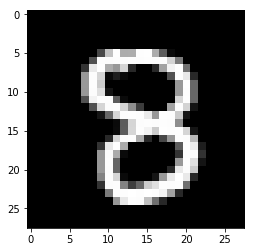


1654784it [00:25, 465086.47it/s]                             

In [6]:
from matplotlib import pyplot
print(train_ds[0][0].shape)
pyplot.imshow(train_ds[0][0].squeeze(), cmap='gray')

In [7]:
import torch.optim as opt




lr = 0.001
model = AutoEncoder()
model.to(device)
print(model)
criterion = nn.MSELoss()
opt = opt.Adam(model.parameters(), lr = lr, weight_decay=1e-5)

AutoEncoder(
  (Encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [8]:
epochs = 10000
out_dir = 'data/mnist_ae_png'
train(epochs, model, train_dl, valid_dl, criterion, opt, out_dir, device)

0 0.05251799397170544


KeyboardInterrupt: 